# Cardiovascular diseases (CVDs) prediction model

In [ ]:
# Проект построен следующим образом.
# Сначала определяются ф-ции, для последующего запуска генетического алгоритма по подбору оптимальных
# гиперпараметров для модели классификации XGBoost (градиентного бустинга)
# 1. Primary Data Handling - обработка сырых данных: Очистка данных, трансформация/разделение признаков, подготовка данных
# 2. Подбор гиперпараметров XGBoost на основе генетического алгоритма и выполнение классификации

# В итоге классификатор XGBoost с подбором гиперпараметров при помощи генетического алгоритма 
# показал точность 92% против 89% с гиперпараметрами по умолчанию

# Таким образом, с точностью 92% можно предсказывать риск возникновения сердечной недостаточности пациента по его анализам

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
from sklearn import ensemble, model_selection, metrics, tree
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error,roc_auc_score,confusion_matrix
from numpy.random import randint
from numpy.random import randn,random
import random as rnd

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import warnings

%matplotlib inline

In [ ]:
#Data features information:
    
#1. Age: age of the patient [years]
#2. Sex: sex of the patient [M: Male, F: Female]
#3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
#4. RestingBP: resting blood pressure [mm Hg]
#5. Cholesterol: serum cholesterol [mm/dl]
#6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
#7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
#8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
#9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
#10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
#11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
#12. HeartDisease: output class [1: heart disease, 0: Normal]

# Define functions for further Genetics run

In [2]:
'''
    Function of getting of the survived botes of the population
        Input parameters:
        - popul - the population
        - val - the current values of the prediction accuracy on the botes for the population
        - nsurv - the number of the survived botes
'''
def getSurvPopul(
        popul,
        val,
        nsurv,
        ):
    newpopul = [] # 2-dimension matrix for new population
    sval = sorted(val, reverse=1) # Sort the val-values on descending
    for i in range(nsurv): # Finally, the best nsurv-botes will be written in a new population 'newpopul'
        index = val.index(sval[i]) # Get the index in list 'val' for the value=sval[i]
        newpopul.append(popul[index]) # Add the bote from the current population with the founded above index in a new population
    return newpopul, sval # Return new population ('nsurv' elements) and the sorted list of function's result on the all the initial botes

'''
    Function to get parents from the survived botes of the population
        Input parameters:
        - curr_popul - the current survived population
        - nsurv - the number of survived botes
'''
def getParents(
        curr_popul,
        nsurv
        ):   
    indexp1 = rnd.randint(0, nsurv - 1) # The random index of the first parent from 0 to 'nsurv - 1'
    indexp2 = rnd.randint(0, nsurv - 1) # The random index of the second parent from 0 to 'nsurv - 1'    
    botp1 = curr_popul[indexp1] # Get the first parent-bote based on index 'indexp1'
    botp2 = curr_popul[indexp2] # Get the second parent-bote based on index 'indexp2'    
    return botp1, botp2 # Return the both parents-botes

'''
    Function of crossing of two parents
        Input parameters:
        - botp1 - the first parent-bote
        - botp2 - the second parent-bote
        - j - number of the feature
'''
def crossPointFrom2Parents(
        botp1,
        botp2, 
        j
        ):
    pindex = rnd.random() # random number from 0 to 1
    if pindex < 0.5:
        x = botp1[j]
    else:
        x = botp2[j]
    return x

In [3]:
'''
    Function of initialization of population of botes. Each bote contents 6 hyperparameters of XGBoost model:

    n_estimators - the number of trees
    learning_rate - gradient step
    max_depth - max depth of the each tree (increasing this value will make the model more complex and more likely to 
                overfit)
    gamma - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, 
            the more conservative the algorithm will be
    min_child_weight - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results 
                       in a leaf node with the sum of instance weight less than min_child_weight, then the building process 
                       will give up further partitioning. In linear regression task, this simply corresponds to minimum 
                       number of instances needed to be in each node. The larger min_child_weight is, the more conservative 
                       the algorithm will be.
    subsample - ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the 
                training data prior to growing trees and this will prevent overfitting. Subsampling will occur once in 
                every boosting iteration.
'''
def initilialize_poplulation(num_botes):
    learningRate = np.empty([num_botes, 1])
    nEstimators = np.empty([num_botes, 1], dtype = np.uint8)
    maxDepth = np.empty([num_botes, 1], dtype = np.uint8)
    minChildWeight = np.empty([num_botes, 1])
    gammaValue = np.empty([num_botes, 1])
    subSample = np.empty([num_botes, 1])
    for i in range(num_botes):
        learningRate[i] = round(rnd.uniform(0.01, 1), 2)
        nEstimators[i] = rnd.randrange(10, 1500, step = 25)
        maxDepth[i] = int(rnd.randrange(1, 10, step= 1))
        minChildWeight[i] = round(rnd.uniform(0.01, 10.0), 2)
        gammaValue[i] = round(rnd.uniform(0.01, 10.0), 2)
        subSample[i] = round(rnd.uniform(0.01, 1.0), 2)
    population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample), axis= 1)
    return population

In [4]:
'''
    Function of mutation
        Input parameters:
            param_n - feature index
            param_val - the value of the feature
            num_of_pars - the number of features in each bote
'''
def mutationXGB(param_n,param_val,num_of_pars):
    #the borders for the each feature
    minMaxValue = np.zeros((num_of_pars, 2))
    minMaxValue[0, :] = [0.01, 1.0] #min/max learning rate
    minMaxValue[1, :] = [10, 2000] #min/max n_estimator
    minMaxValue[2, :] = [1, 15] #min/max depth
    minMaxValue[3, :] = [0, 10.0] #min/max child_weight
    minMaxValue[4, :] = [0.01, 10.0] #min/max gamma
    minMaxValue[5, :] = [0.01, 1.0] #min/max subsample
 
    # First set the change of the feature
    if param_n == 0: #learning_rate
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if param_n == 1: #n_estimators
        mutationValue = np.random.randint(-200, 200)
    if param_n == 2: #max_depth
        mutationValue = np.random.randint(-5, 5)
    if param_n == 3: #min_child_weight
        mutationValue = round(np.random.uniform(5, 5), 2)
    if param_n == 4: #gamma
        mutationValue = round(np.random.uniform(-2, 2), 2)
    if param_n == 5: #subsample
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
  
    # new feature value = old feature value + change of the feature
    mutated_param = param_val + mutationValue
    # keep the new feature value within the borders
    if(mutated_param > minMaxValue[param_n, 1]):
        mutated_param = minMaxValue[param_n, 1]
    if(mutated_param < minMaxValue[param_n, 0]):
        mutated_param = minMaxValue[param_n, 0]      
    return mutated_param

# 1. Primary data handling

In [5]:
df=pd.read_csv('Data/heart.csv')

In [6]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
# look is the data balanced or not
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [8]:
# transform categorical data to numeric
df.loc[df['Sex'] == 'M', 'Sex'] = 1
df.loc[df['Sex'] == 'F', 'Sex'] = 0
df.loc[df['ChestPainType'] == 'ASY', 'ChestPainType'] = 0
df.loc[df['ChestPainType'] == 'NAP', 'ChestPainType'] = 1
df.loc[df['ChestPainType'] == 'ATA', 'ChestPainType'] = 2
df.loc[df['ChestPainType'] == 'TA', 'ChestPainType'] = 3
df.loc[df['RestingECG'] == 'Normal', 'RestingECG'] = 0
df.loc[df['RestingECG'] == 'LVH', 'RestingECG'] = 1
df.loc[df['RestingECG'] == 'ST', 'RestingECG'] = 2
df.loc[df['ExerciseAngina'] == 'Y', 'ExerciseAngina'] = 1
df.loc[df['ExerciseAngina'] == 'N', 'ExerciseAngina'] = 0
df.loc[df['ST_Slope'] == 'Flat', 'ST_Slope'] = 0
df.loc[df['ST_Slope'] == 'Up', 'ST_Slope'] = 1
df.loc[df['ST_Slope'] == 'Down', 'ST_Slope'] = 2

df = df.astype({"Sex": int, "ChestPainType": int, "RestingECG": int, "ExerciseAngina": int, "ST_Slope": int})

In [9]:
# look are there some undefined values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

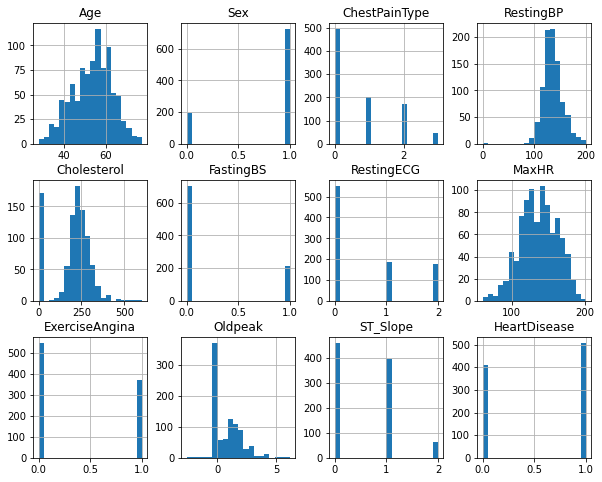

In [11]:
# look on the statistics of the data
df.hist(bins=20, figsize=(10,8),layout=(3,4));

In [10]:
# based on distribution above, remove outliers by changing 0-value of RestingBP to the median
df.loc[df['RestingBP'] < 50, 'RestingBP'] = df['RestingBP'].median()

<IPython.core.display.Javascript object>

C:\Users\Roman\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Roman\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Roman\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Roman\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


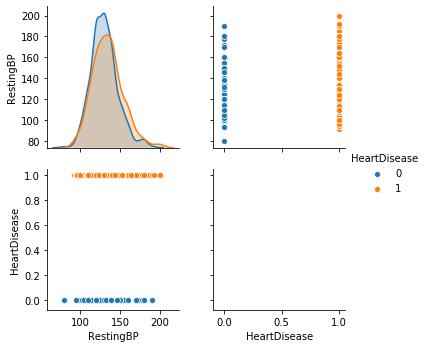

In [11]:
# look on the transformed 'RestingBP', be sure that there are no more outliers
sns.pairplot(df[['RestingBP','HeartDisease']], hue="HeartDisease",height=2.5)

In [13]:
df.dtypes

Age                 int64
Sex                 int32
ChestPainType       int32
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int32
MaxHR               int64
ExerciseAngina      int32
Oldpeak           float64
ST_Slope            int32
HeartDisease        int64
dtype: object

In [53]:
df.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,0.748366,132.538126,198.799564,0.233115,0.592593,136.809368,0.404139,0.887364,0.567538,0.553377
std,9.432617,0.407701,0.931031,17.990127,109.384145,0.423046,0.793670,25.460334,0.490992,1.066570,0.618959,0.497414
min,28.000000,0.000000,0.000000,80.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,0.000000,120.000000,173.250000,0.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,1.000000,0.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,0.000000,1.000000
75%,60.000000,1.000000,1.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,1.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


In [54]:
df.shape

(918, 12)

In [15]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,1,160,180,0,0,156,0,1.0,0,1
2,37,1,2,130,283,0,2,98,0,0.0,1,0
3,48,0,0,138,214,0,0,108,1,1.5,0,1
4,54,1,1,150,195,0,0,122,0,0.0,1,0


In [12]:
# Transform each categorical column to multiple columns

def to_categorical(arg,vect_len):
    vect = np.zeros(vect_len)
    vect[int(arg)] = 1.0
    return vect

#d - input original value (string)
#dVar - np-array of all variants for that data
def categ_trans(d, dVar):
    dVar = list(dVar)
    #Find an index of the value in all variants array
    if d in dVar:
        ind = dVar.index(d)
        #one hot encoding
        ind = to_categorical(ind, len(dVar))
    else:
        ind = np.zeros(len(dVar))
    return ind

# Age categories
def age_categ(age):
    if age <= 32:
        return [1.0,0,0,0,0,0,0,0,0,0]
    if (age >= 33) & (age <= 37):
        return [0,1.0,0,0,0,0,0,0,0,0,0]
    if (age >= 38) & (age <= 42):
        return [0,0,1.0,0,0,0,0,0,0,0]
    if (age >= 43) & (age <= 47):
        return [0,0,0,1.0,0,0,0,0,0,0]
    if (age >= 48) & (age <= 52):
        return [0,0,0,0,1.0,0,0,0,0,0]
    if (age >= 53) & (age <= 57):
        return [0,0,0,0,0,1.0,0,0,0,0]
    if (age >= 58) & (age <= 62):
        return [0,0,0,0,0,0,1.0,0,0,0]
    if (age >= 63) & (age <= 67):
        return [0,0,0,0,0,0,0,1.0,0,0]
    if (age >= 68) & (age <= 72):
        return [0,0,0,0,0,0,0,0,1.0,0]
    if age >= 73:
        return [0,0,0,0,0,0,0,0,0,1.0]

In [13]:
# create the list of new columns after data transformation
cols = []
for age in range(len(age_categ(42))):  #any age is ok, 42 - just random
    cols.append("Age"+str(age))
for sex in range(len(df.Sex.unique())):
    cols.append("Sex"+str(sex))
for cpt in range(len(df.ChestPainType.unique())):
    cols.append("ChestPainType"+str(cpt))
cols.append("RestingBP")
cols.append("Cholesterol")
for fbs in range(len(df.FastingBS.unique())):
    cols.append("FastingBS"+str(fbs))
for ecg in range(len(df.RestingECG.unique())):
    cols.append("RestingECG"+str(ecg))
cols.append("MaxHR")
for ang in range(len(df.ExerciseAngina.unique())):
    cols.append("ExerciseAngina"+str(ang))
cols.append("Oldpeak")
for sts in range(len(df.ST_Slope.unique())):
    cols.append("ST_Slope"+str(sts))
cols.append("HeartDisease")

In [14]:
# Function creating data from the dataframe in the right format for further implementation 
# d - string from dataframe
def getAllParameters(d):
    Age = age_categ(d.Age)
    Sex = categ_trans(d.Sex,sorted(df.Sex.unique()))
    ChestPainType = categ_trans(d.ChestPainType,sorted(df.ChestPainType.unique()))
    FastingBS = categ_trans(d.FastingBS,sorted(df.FastingBS.unique()))
    RestingECG = categ_trans(d.RestingECG,sorted(df.RestingECG.unique()))
    ExerciseAngina = categ_trans(d.ExerciseAngina,sorted(df.ExerciseAngina.unique()))
    ST_Slope = categ_trans(d.ST_Slope,sorted(df.ST_Slope.unique()))
    
    out = list(Age)
    out.extend(Sex)
    out.extend(ChestPainType)
    out.append(d.RestingBP)
    out.append(d.Cholesterol)
    out.extend(FastingBS)
    out.extend(RestingECG)
    out.append(d.MaxHR)
    out.extend(ExerciseAngina)
    out.append(d.Oldpeak)
    out.extend(ST_Slope)
    return out

<IPython.core.display.Javascript object>

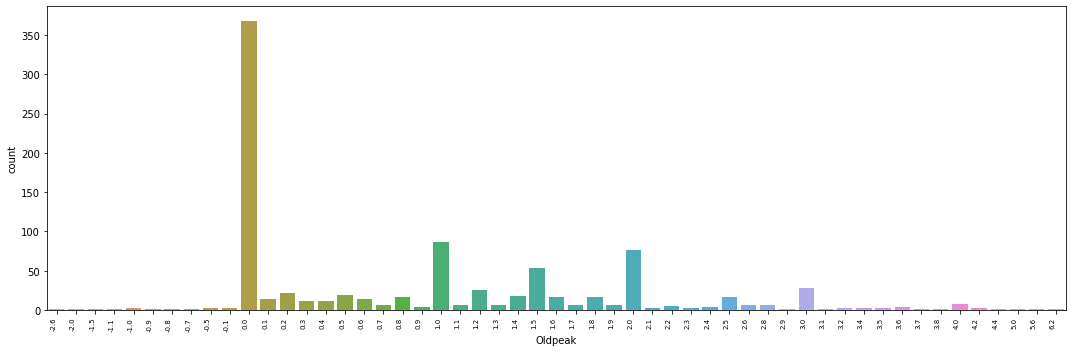

In [15]:
# Visualization of the features distribution (here 'Oldpeak' feature for example)
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,5))
ax = sns.countplot(df.Oldpeak)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=7)
plt.tight_layout()
plt.show()

In [16]:
%%time
#creating data from the dataframe in the right format for further implementation  
warnings.filterwarnings('ignore')
data = []
for i in range(df.shape[0]):
    data.append(getAllParameters(df.iloc[i]))

Wall time: 1.24 s


In [17]:
# create DataFrame object from data
warnings.filterwarnings('ignore')
df_mod = pd.DataFrame(data,columns=cols)
df_mod['HeartDisease'] = df['HeartDisease']

### 1.2 Preparing data for model input

In [18]:
warnings.filterwarnings('ignore')
#defining features and target variable
X = df_mod.drop(['HeartDisease'],axis=1) 
y = df_mod['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [19]:
# normalization of the features
xScaler = StandardScaler()
xScaler.fit(X_train)
X_train = xScaler.transform(X_train)
X_test = xScaler.transform(X_test)

# 2. Genetic Run to find the optimal set of input parameters of XGBoost model

In [28]:
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [20]:
%%time
warnings.filterwarnings('ignore')

n = 40 # the population size
nsurv = int(0.2*n) # the size of the survived botes in population
nnew = n - nsurv # the number of new botes (after keeping the best 'nsurv' botes)
l = 6 # the length of bote (number of features)
epohs = 15 # number of epochs (how many times we change population)

popul = initilialize_poplulation(n) # Creates random population: [n, l] matrix

for it in range(epohs):  
    val = [] # 1-dimension array of the model precision (or error for regression problem) on the botes features

    for i in range(n):
        bot = popul[i] # the current bote
    
        # run the model on the features from the current bote
        XGB_i = xgb.XGBClassifier(
            verbosity=0,
            learning_rate=bot[0],
            n_estimators=int(bot[1]),
            max_depth=int(bot[2]),
            min_child_weight=bot[3],
            gamma=bot[4],
            subsample=bot[5])
        XGB_i.fit(X_train, y_train)
        # add the prediction score for the current bote based on cross-validation accuracy to the 'val' array
        val.append(round(cross_val_score(estimator=XGB_i,X=X_test,y=y_test,cv=10).mean(),3))
    
    newpopul, sval = getSurvPopul(popul, val, nsurv) # Get the survived botes of population and sorted botes scores
    print(it, " ", [round(s,8) for s in sval[0:6]]) # print scores for 6 best botes
 
    for i in range(nnew): # run cycle 'n-nsurv' times to fill the rest of the new population based on the survived botes  
        botp1, botp2 = getParents(newpopul, nsurv) # Get from the survived botes-population two random parents
        newbot = [] # set new bote which will be borned from the choosen parents above
        # each feature of the new bote is crossing the features of the parents
        for j in range(l):
            # j-th feature of the new bote:
            x = crossPointFrom2Parents(botp1, botp2, j)        
            newbot.append(x)
        #Introduce mutation in a random feature of the borned bote
        j_mut = np.random.randint(0, l)
        newbot[j_mut] = mutationXGB(j_mut,newbot[j_mut],l) 
        newpopul.append(newbot) # Add this bote in new population of the survived botes
        #so we finally add 'n-nsurv' new borned botes to the survived botes
    
    popul = newpopul # Write the new created population in 'popul'

0   [0.902, 0.897, 0.886, 0.88, 0.875, 0.87]
1   [0.902, 0.897, 0.897, 0.886, 0.886, 0.886]
2   [0.918, 0.908, 0.902, 0.897, 0.897, 0.897]
3   [0.919, 0.918, 0.908, 0.907, 0.903, 0.902]
4   [0.919, 0.919, 0.918, 0.913, 0.908, 0.908]
5   [0.919, 0.919, 0.919, 0.918, 0.918, 0.913]
6   [0.919, 0.919, 0.919, 0.919, 0.918, 0.918]
7   [0.919, 0.919, 0.919, 0.919, 0.919, 0.919]
8   [0.919, 0.919, 0.919, 0.919, 0.919, 0.919]
9   [0.919, 0.919, 0.919, 0.919, 0.919, 0.919]
10   [0.919, 0.919, 0.919, 0.919, 0.919, 0.919]
11   [0.919, 0.919, 0.919, 0.919, 0.919, 0.919]
12   [0.919, 0.919, 0.919, 0.919, 0.919, 0.919]
13   [0.919, 0.919, 0.919, 0.919, 0.919, 0.919]
14   [0.919, 0.919, 0.919, 0.919, 0.919, 0.919]
Wall time: 4min 42s


In [21]:
#print the features of the best bote
best_bot = popul[0]
print("Learning rate = ",best_bot[0])
print("Trees number = ",best_bot[1])
print("Max depth = ",best_bot[2])
print("min_child_weight = ",best_bot[3])
print("gamma = ",best_bot[4])
print("subsample = ",best_bot[5])

Learning rate =  0.39
Trees number =  10.0
Max depth =  4.0
min_child_weight =  0.35
gamma =  0.39
subsample =  0.89


In [22]:
# run the model on the features of the best bote
XGB_best = xgb.XGBClassifier(
            verbosity=0,
            learning_rate=best_bot[0],
            n_estimators=int(best_bot[1]),
            max_depth=int(best_bot[2]),
            min_child_weight=best_bot[3],
            gamma=best_bot[4],
            subsample=best_bot[5])
XGB_best.fit(X_train, y_train)
XGB_accuracies=cross_val_score(estimator=XGB_best,X=X_test,y=y_test,cv=10)
 
print("Mean Accuracy: ",XGB_accuracies.mean())
xgb_pred=XGB_best.predict(X_test)
print("Accuracy on testing dataset: ",accuracy_score(y_test,xgb_pred))

Mean Accuracy:  0.9187134502923977
Accuracy on testing dataset:  0.8858695652173914


Confusion Matrix For XGBoost


<IPython.core.display.Javascript object>

(2.0, 0.0)

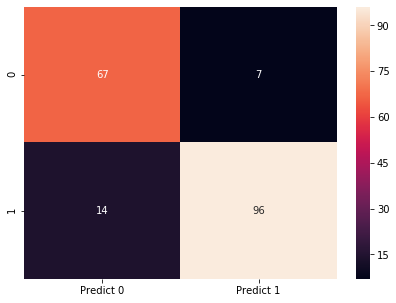

In [26]:
print("Confusion Matrix For XGBoost")
cm=confusion_matrix(y_test,xgb_pred, labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in [0,1]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
plt.figure(figsize = (7,5))
ax = sns.heatmap(df_cm, annot=True)

i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5) #устанавливаем границы вручную

In [24]:
# run the model on the default features (for comparison)
XGB_default = xgb.XGBClassifier()
XGB_default.fit(X_train, y_train)
XGB_accuracies=cross_val_score(estimator=XGB_default,X=X_test,y=y_test,cv=10)
 
print("Mean Accuracy: ",XGB_accuracies.mean())
xgb_pred=XGB_default.predict(X_test)
print("Accuracy on testing dataset: ",accuracy_score(y_test,xgb_pred))

Mean Accuracy:  0.8967836257309942
Accuracy on testing dataset:  0.8858695652173914
